<a href="https://colab.research.google.com/github/gbam-ds/Lista/blob/main/Lista_GBaroni.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdução

A resolução da lista de Machine Learning está nesse notebook. Ele se divide em mais duas seções, sendo uma para cada exercício. Há ainda sub-seções para melhor orientar o processo lógico, então, por favor, acompanhe o índice.

Vale ressaltar que esse notebook e a base de dados primáris são encontrados no meu [github](https://github.com/gbam-ds/Lista).

#Exercício 01

## Introdução e Resultados

O objetivo desse exercício é melhorar o MAPE (*Mean Absolute Percentage Error*) depois da utilização dos modelos vistos até agora. Em aula, atingimos uma acurácia em torno de 8-9%, como será apresentado em seguida.

Para melhorar a acurácia, três abordagens foram investigadas. A primeira é o pré-tratamento de dados, em que testei ___. A segunda é em relação as features, em que fiz ___. A terceira é a eliminação de variáveis, em que retirei ___.

Os resultados foram os seguintes: consegui reduzir o MAPE para ___, fazendo a b e c.


## Código de aula

In [ ]:
# Core
import pandas as pd
import numpy as np
from scipy.stats import skew
from scipy.stats import norm
from scipy import stats
%matplotlib inline
from mlxtend.regressor import StackingCVRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error


# Visual
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 7.5]
import plotly.express as px
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')



#Scikit
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split



from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV


Trabalhando com a base

In [ ]:
url = 'https://raw.githubusercontent.com/gbam-ds/Lista/main/train.csv'
df = pd.read_csv(url, index_col=0)
train, test = train_test_split(df, test_size=0.3, random_state=7)
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'], #excluindo ID  
                      test.loc[:,'MSSubClass':'SaleCondition'])) #e SalePrice
#pq não pegou de df direto?

#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

#nao entendi passagem de baixo
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

#pq nao logou salesprice junto das outras numericas?
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])
all_data = pd.get_dummies(all_data)

#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

#creating matrices for sklearn:
#oq significa mesmo?
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y_train = train.SalePrice
y_test = test.SalePrice

####Definindo MAPE

In [ ]:
def mape(Y_actual, Y_Predicted):
    mape = round(np.mean(np.abs( Y_actual - Y_Predicted)/Y_actual)*100, 2)
    return mape

#### Modeling

In [ ]:
#linear regression - scikit learn
linear_reg = LinearRegression()
linear_reg.fit(X_train[['GrLivArea']], y_train)
pred_linear = linear_reg.predict(X_test[['GrLivArea']])

mape( y_test, np.exp(pred_linear))

21.77

In [ ]:
#ridge
ridge_reg = Ridge(alpha = 0.5)
ridge_reg.fit(X_train, y_train)
ridge_pred = ridge_reg.predict(X_test)

mape( y_test, np.exp(ridge_pred) )

9.09

## Melhorando o código

Dá para melhorar o MAPE facilmente, com base no código de aula. No entanto, vamos melhorar ainda mais :)

In [ ]:
#linear regression - scikit learn
#melhorando o codigo de aula com as variaveis de impacto maior de .5

x_list = ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'FullBath', 'YearBuilt', 'TotalBsmtSF', 'YearRemodAdd', '1stFlrSF',
       'TotRmsAbvGrd', 'GarageYrBlt']

linear_reg = LinearRegression()
linear_reg.fit(X_train[x_list], y_train)
pred_linear = linear_reg.predict(X_test[x_list])

mape( y_test, np.exp(pred_linear))

12.37

In [ ]:
#ridge
ridge_reg = Ridge(alpha = 5) #melhoramos o mape alterando o alpha
ridge_reg.fit(X_train, y_train)
ridge_pred = ridge_reg.predict(X_test)

mape( y_test, np.exp(ridge_pred) )

8.63

### Conhecendo os dados

In [ ]:
url = 'https://raw.githubusercontent.com/gbam-ds/Lista/main/train.csv'
df = pd.read_csv(url, index_col=0)
train, test = train_test_split(df, test_size=0.3, random_state=7)

In [ ]:
#missing data
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1018,0.996086
MiscFeature,987,0.965753
Alley,954,0.933464
Fence,825,0.807241
FireplaceQu,471,0.460861
LotFrontage,188,0.183953
GarageCond,60,0.058708
GarageQual,60,0.058708
GarageType,60,0.058708
GarageFinish,60,0.058708


In [ ]:
#ID não agrega em nada, entao vou tirar
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

KeyError: ignored

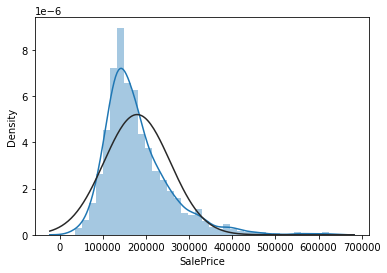

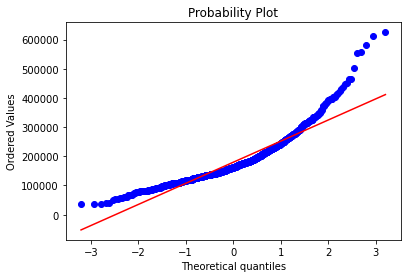

In [ ]:
#analisando y com histograma e plot de distribuicao de probabilidade
sns.distplot(train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)

Como é possível ver, SalePrice tem *'peakedness'*, *'positive skewness'* e não segue a linha de distribuição normal da diagonal. Como temos um caso de *'positive skewness'*, aplicar log deve resolver.

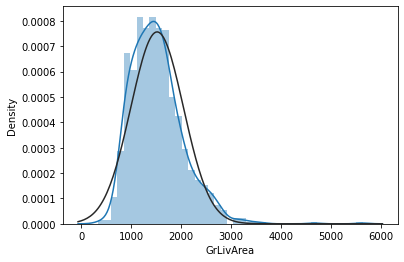

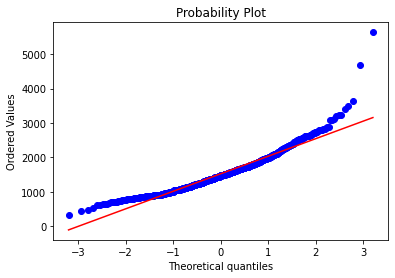

In [ ]:
# histograma e probabilidade normal
sns.distplot(train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['GrLivArea'], plot=plt)

GrLivArea também apresenta skewness, então também vou logar. Além disso, vou retirar possíveis outliers que tiverem valor superior a 4500.


In [ ]:
train = train[train.GrLivArea < 4500]
train.reset_index(drop=True, inplace=True)
train["SalePrice"] = np.log1p(train["SalePrice"])
y = train['SalePrice'].reset_index(drop=True)

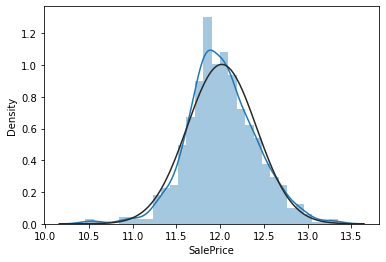

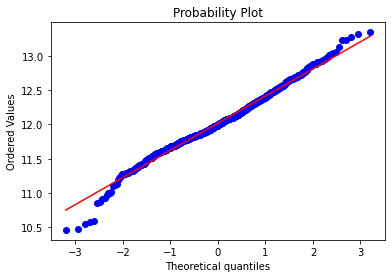

In [ ]:
# vendo se funcionou
sns.distplot(train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)

Funcionou!

### Organizando os dados


In [ ]:
#tirando SalePrice do conjunto de treino
train_features = train.drop(['SalePrice'], axis=1)
test_features = test
features = pd.concat([train_features, test_features]).reset_index(drop=True)

#com features, dá para tratar missing values de uma vez

In [ ]:
#essas variáveis são categóricas, então preciso fazer com que o python 
#as leia como str e não como número
features['MSSubClass'] = features['MSSubClass'].apply(str)
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)

In [ ]:
pd.set_option('display.max_columns', None)
features.sort_index(axis=1, inplace=True)
features.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,CentralAir,Condition1,Condition2,Electrical,EnclosedPorch,ExterCond,ExterQual,Exterior1st,Exterior2nd,Fence,FireplaceQu,Fireplaces,Foundation,FullBath,Functional,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,GrLivArea,HalfBath,Heating,HeatingQC,HouseStyle,KitchenAbvGr,KitchenQual,LandContour,LandSlope,LotArea,LotConfig,LotFrontage,LotShape,LowQualFinSF,MSSubClass,MSZoning,MasVnrArea,MasVnrType,MiscFeature,MiscVal,MoSold,Neighborhood,OpenPorchSF,OverallCond,OverallQual,PavedDrive,PoolArea,PoolQC,RoofMatl,RoofStyle,SaleCondition,SalePrice,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,923,0,0,NaN,2,TwnhsE,TA,No,543,119,BLQ,BLQ,0,0,Gd,261,Y,Norm,Norm,SBrkr,0,TA,TA,Plywood,Plywood,NaN,TA,1,CBlock,2,Typ,264,1,TA,RFn,TA,Attchd,1980.0,923,0,GasA,TA,1Story,1,TA,Lvl,Gtl,8012,Inside,50.0,Reg,0,120,RL,0.0,None,NaN,0,5,SawyerW,0,5,6,Y,0,NaN,CompShg,Gable,Normal,NaN,WD,0,Pave,5,923,AllPub,80,1980,1980,2010
1,1578,0,0,NaN,3,1Fam,TA,No,0,0,Unf,Unf,0,0,Gd,1573,Y,Norm,Norm,SBrkr,0,TA,Gd,CemntBd,CmentBd,NaN,Gd,1,PConc,2,Typ,840,3,TA,Fin,TA,Attchd,2008.0,1578,0,GasA,Ex,1Story,1,Ex,Lvl,Gtl,9262,Inside,78.0,Reg,0,20,RL,194.0,Stone,NaN,0,5,Somerst,36,5,8,Y,0,NaN,CompShg,Gable,Partial,NaN,New,0,Pave,7,1573,AllPub,0,2008,2009,2009
2,879,984,0,NaN,4,1Fam,TA,Av,0,0,Unf,Unf,0,0,Gd,879,Y,Norm,Norm,SBrkr,0,TA,Gd,VinylSd,VinylSd,NaN,Gd,1,PConc,2,Typ,660,3,TA,Fin,TA,BuiltIn,2006.0,1863,1,GasA,Ex,2Story,1,Gd,Lvl,Gtl,14054,Inside,58.0,IR1,0,60,RL,0.0,None,NaN,0,11,Gilbert,17,5,7,Y,0,NaN,CompShg,Gable,Partial,NaN,New,0,Pave,9,879,AllPub,100,2006,2006,2006
3,2898,0,0,NaN,2,1Fam,TA,Av,1165,400,ALQ,LwQ,1,0,Gd,0,Y,Norm,Norm,SBrkr,174,TA,Gd,Stone,HdBoard,NaN,Gd,1,CBlock,2,Typ,665,2,TA,Fin,TA,Attchd,1976.0,2898,0,GasA,TA,1Story,1,Gd,Lvl,Gtl,15498,Corner,NaN,IR1,0,20,RL,0.0,None,NaN,0,5,Timber,72,6,8,Y,0,NaN,WdShake,Hip,Abnorml,NaN,COD,0,Pave,10,1565,AllPub,0,1976,1976,2008
4,774,1194,0,NaN,4,1Fam,TA,No,0,0,Unf,Unf,0,0,Ex,774,Y,Norm,Norm,SBrkr,0,TA,Gd,VinylSd,VinylSd,NaN,Gd,1,PConc,2,Typ,680,3,TA,Fin,TA,BuiltIn,2009.0,1968,1,GasA,Ex,2Story,1,Ex,Lvl,Gtl,12003,Corner,92.0,Reg,0,60,RL,84.0,BrkFace,NaN,0,5,Timber,75,5,8,Y,0,NaN,CompShg,Gable,Partial,NaN,New,0,Pave,8,774,AllPub,0,2009,2010,2010


In [ ]:
features["Functional"].value_counts()

Typ     1358
Min2      34
Min1      31
Mod       15
Maj1      14
Maj2       5
Sev        1
Name: Functional, dtype: int64

In [ ]:
features["Electrical"].value_counts()

SBrkr    1332
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [ ]:
features["KitchenQual"].value_counts()

TA    735
Gd    586
Ex     98
Fa     39
Name: KitchenQual, dtype: int64

In [ ]:
#preenchendo com os mais frequentes
#analise exploratória das variaveis feita no excel, aqui só arrumo os dados
features['Functional'] = features['Functional'].fillna('Typ') 
features['Electrical'] = features['Electrical'].fillna("SBrkr") 
features['KitchenQual'] = features['KitchenQual'].fillna("TA") 
features["PoolQC"] = features["PoolQC"].fillna("None")

features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0]) 
features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

Além disso, se falta dado para as informações de garagem, provavelmente a casa não possui uma.

In [ ]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    features[col] = features[col].fillna(0)

for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    features[col] = features[col].fillna('None')

    
# o mesmo com o porão

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('None')

In [ ]:
#penso em covariancia aqui, entao MSZoning será semelhante a MSSubClass
features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

In [ ]:
#None para os demais objetos
objects = []
for i in features.columns:
    if features[i].dtype == object:
        objects.append(i)
features.update(features[objects].fillna('None'))

In [ ]:
#LotFrontage tem muita informação para ser deletada, entao preencho com o valor médio
features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

#0 para os demais numeros
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics.append(i)
features.update(features[numerics].fillna(0))

In [ ]:
#corrigindo skewness das demais
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics2.append(i)
skew_features = features[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

for i in skew_index:
    features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))

### Feature Engineering

In [ ]:
# retirando
features = features.drop(['Utilities', 'Street', 'PoolQC',], axis=1)

#inserindo
features['YrBltAndRemod'] = features['YearBuilt'] + features['YearRemodAdd']
features['TotalSF'] = features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']

features['Total_SF'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
                                 features['1stFlrSF'] + features['2ndFlrSF'])

features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) +
                               features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))

features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                              features['EnclosedPorch'] + features['ScreenPorch'] +
                              features['WoodDeckSF'])

In [ ]:
#aplicando logica
features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 
                                                 else 0)
features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 
                                                     else 0)
features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 
                                                     else 0)
features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 
                                                    else 0)
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 
                                                        else 0)

In [ ]:
#one-hot enconding para as categoricas serem computaveis
final_features = pd.get_dummies(features).reset_index(drop=True)
final_features.shape

(1458, 333)

In [ ]:
#spliting again
X = final_features.iloc[:len(y), :]
X_sub = final_features.iloc[len(y):, :]


,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,Fireplaces,FullBath,GarageArea,GarageCars,GarageYrBlt,GrLivArea,HalfBath,KitchenAbvGr,LotArea,LotFrontage,LowQualFinSF,MasVnrArea,MiscVal,OpenPorchSF,OverallCond,OverallQual,PoolArea,SalePrice,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrBltAndRemod,TotalSF,Total_SF,Total_Bathrooms,Total_porch_sf,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace,Alley_Grvl,Alley_None,Alley_Pave,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,CentralAir_N,CentralAir_Y,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Po,FireplaceQu_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_None,GarageCond_Po,GarageCond_TA,GarageFinish_Fin,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MoSold_1,MoSold_10,MoSold_11,MoSold_12,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,

### Outliers

In [ ]:
#base já anunciou alguns outliers
outliers = [30, 88, 462, 631, 1322]
X = X.drop(X.index[outliers])
y = y.drop(y.index[outliers])

In [ ]:
overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99.90:
        overfit.append(i)

overfit = list(overfit)
X = X.drop(overfit, axis=1)
X_sub = X_sub.drop(overfit, axis=1)
overfit

Então, não preciso dropar

###Modeling

In [ ]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

#funcoes de erro

def mape(y,y_pred):
    mape = (mean_absolute_percentage_error(y, y_pred))
    return mape

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [ ]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [ ]:
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kfolds))
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))                       

In [ ]:
print("Com rmse:")

score = cv_rmse(ridge , X)
print("Ridge: {:.4f} ({:.4f})\n".format(score.mean(), score.std()) )

score = cv_rmse(lasso , X)
print("LASSO: {:.4f} ({:.4f})\n".format(score.mean(), score.std()) )

score = cv_rmse(elasticnet)
print("elastic net: {:.4f} ({:.4f})\n".format(score.mean(), score.std()) )

Com rmse:
Ridge: 0.1119 (0.0179)

LASSO: 0.1096 (0.0160)

elastic net: 0.1095 (0.0161)



Será que dá para melhorar?
O Prof. Curado falou certa vez de uma técnica de blending para os modelos. Vou testar :)

### Blending

In [ ]:
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet),
                                meta_regressor = lasso,
                                use_features_in_secondary=True)

In [ ]:
stack_gen_model = stack_gen.fit(np.array(X), np.array(y))

elastic_model_full_data = elasticnet.fit(X, y)

lasso_model_full_data = lasso.fit(X, y)

ridge_model_full_data = ridge.fit(X, y)

Blending os modelos

In [ ]:
def blend_models_predict(X):
    return ((0.20 * elastic_model_full_data.predict(X)) + \
            (0.15 * lasso_model_full_data.predict(X)) + \
            (0.25 * ridge_model_full_data.predict(X)) + \
            (0.4 * stack_gen_model.predict(np.array(X))))

In [ ]:
print('MAPE score:')
print(mape(y, blend_models_predict(X)))
print('')
print('RMSLE score:')
print(rmsle(y, blend_models_predict(X)))

MAPE score:
0.005368063334987904

RMSLE score:
0.09249909740383559
